## Model description

Reference: https://easychair.org/publications/paper/1ff2

Three-dimensional ODE of the plant without discrete-time PI-controller:

$$
   \left\{ \begin{array}{lcl}
   \dot{I} & = & \frac{1}{L}\cdot\left( \left(K_P\cdot\left(x_0-x\right)+K_I\cdot x_c \right) - I\cdot\left(R - \frac{K^2}{d_{rot}}\right)\right) \\
   \dot{x} & = & \frac{K}{i\cdot d_{rot}}\cdot I \\
   \dot{x_c} & = & x_0-x \end{array}
   \right.
$$

In [1]:
using Reachability, TaylorIntegration, MathematicalSystems, HybridSystems, SparseArrays
include("helper.jl")

times (generic function with 2 methods)

## Nonlinear solver

In [2]:
@taylorize function EMBrake!(du, u, p, t)
    local L    = 1.e-3
    local KP   = 10000.
    local KI   = 1000.
    local x0   = 0.05
    local R    = 0.3
    local K    = 0.02
    local drot = 0.1
    local i    = 113.1167
    
    du[1] = 1/L * (KP * (x0-u[2]) + KI * u[3] - u[1] * (R + K^2/drot))
    du[2] = u[1] * K/i/drot
    du[3] = x0 - u[2]
end

### Reachability settings

In [3]:
I₀  = Interval(0., 0.)
x₀  = Interval(0., 0.)
xc₀ = Interval(0., 0.)

X₀ = I₀ × x₀ × xc₀

S = BlackBoxContinuousSystem(EMBrake!, 3)
P = InitialValueProblem(S, X₀);

### Results

In [4]:
alg = TMJets(Options(:max_steps=>10_000, :abs_tol=>1e-10, :orderT=>6, :orderQ=>2))
@time sol = solve(P, Options(:T=>0.2), op=alg);
F = sol.flowpipes[1];

 24.798959 seconds (94.28 M allocations: 5.608 GiB, 6.81% gc time)


In [5]:
using Plots, LaTeXStrings

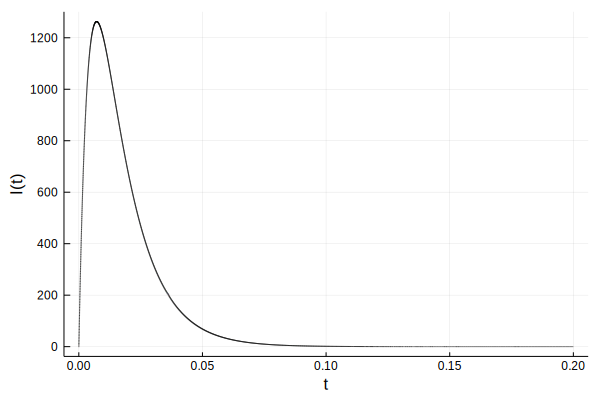

In [6]:
# I vs t
Xk_1 = project(F, [1])
tiempos = times(F)
I_vs_t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];

plot(I_vs_t, xlab="t", ylab="I(t)")

## Linear solver

In [7]:
function EMBrake_lineal()
    L    = 1.e-3
    KP   = 10000.
    KI   = 1000.
    x0   = 0.05
    R    = 0.3
    K    = 0.02
    drot = 0.1
    i    = 113.1167
    
    # ecuaciones no lineales
    #du[1] = 1/L * (KP * (x0-u[2]) + KI * u[3] - u[1] * (R + K^2/drot))
    #du[2] = u[1] * K/i/drot
    #du[3] = x0 - u[2]
    
    # ecuaciones escritas como x' = Ax + b
    A = [-(R + K^2/drot)/L   -KP/L    KI/L;
          K/(i*drot)          0.0     0.0;
              0              -1.0       0]
    b = [x0*KP/L, 0.0, x0]

    return AffineContinuousSystem(A, b)
end

EMBrake_lineal (generic function with 1 method)

### Reachability settings

In [8]:
I₀  = Interval(0., 0.)
x₀  = Interval(0., 0.)
xc₀ = Interval(0., 0.)
X₀ = I₀ × x₀ × xc₀;
S = EMBrake_lineal()
P = InitialValueProblem(S, X₀);

### Results

In [11]:
alg = BFFPSV18(:δ=>1e-5)
@time sol = solve(P, Options(:T => 0.2, :verbosity=>2), op=alg);
F = sol.flowpipes[1];

[info] Reachable States Computation...
[info] Time discretization...
[info] elapsed time: 1.914e-03 seconds
[info] - Decomposing X0
[info] elapsed time: 3.219e-05 seconds
[info] - Computing successors
[info] elapsed time: 2.781e-01 seconds
[info] - Total
[info] elapsed time: 2.816e-01 seconds
  0.282484 seconds (4.26 M allocations: 216.666 MiB, 34.46% gc time)


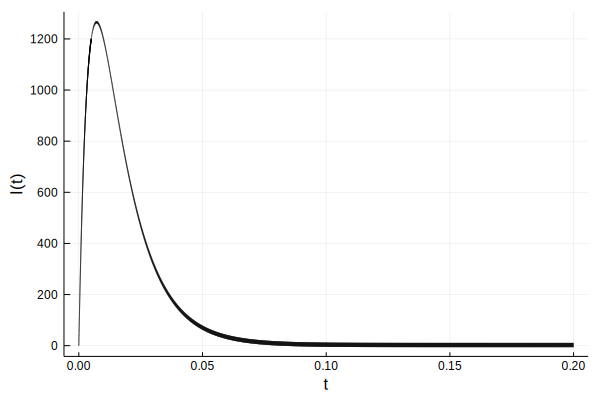

In [19]:
Xk_1 = project(F, [1])
tiempos = times(F)
I_vs_t = [tiempos[i] × Xk_1[i] for i in eachindex(tiempos)];
plot(vcat(I_vs_t[1:1:500], I_vs_t[501:10:end]), xlab="t", ylab="I(t)")